# FIG CESM run evaluations

In [1]:
import os
import sys
import yaml
import argparse
from glob import glob
from datetime import datetime, timedelta

import numpy as np
import xarray as xr

sys.path.insert(0, os.path.realpath('../libs/'))
import graph_utils as gu
#import verif_utils as vu

In [2]:
import pandas as pd

In [3]:
import matplotlib.dates as mdates

In [4]:
import cmaps
# graph tools
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
import matplotlib.colorbar as cbar
import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import cartopy.crs as ccrs
import cartopy.mpl.geoaxes
import cartopy.feature as cfeature

%matplotlib inline

In [5]:
import matplotlib.lines as mlines

In [6]:
fig_keys = {
    'dpi': 150, 
    'orientation':'portrait', 
    'bbox_inches':'tight', 
    'pad_inches':0.1, 
    'transparent':False
}

In [7]:
need_publish = False

if need_publish:
    dpi_ = fig_keys['dpi']
else:
    dpi_ = 75

In [8]:
from numpy.lib.stride_tricks import sliding_window_view

def moving_average_axis(a, window, axis=-1, pad_mode="reflect"):
    a = np.asarray(a, dtype=float)
    if window < 1:
        raise ValueError("window must be >= 1")

    # asymmetric split works for even/odd windows
    pad_left  = (window - 1) // 2
    pad_right =  window // 2

    # Build pad widths for all axes; pad only along the chosen axis
    pad_widths = [(0, 0)] * a.ndim
    pad_widths[axis] = (pad_left, pad_right)

    apad = np.pad(a, pad_widths, mode=pad_mode)

    # Sliding windows along `axis`, then average over the last dim (window)
    sw = sliding_window_view(apad, window_shape=window, axis=axis)
    return sw.mean(axis=-1)

## Prep data

In [9]:
# ===================== #
# timeseries
fn = '/glade/campaign/ral/hap/ksha/GWC_results/CESM_scores/CESM_SSP_T2_tmean.zarr'
LENS_SSP = xr.open_zarr(fn)['VAR_2T'].values
LENS_SSP_ave = moving_average_axis(LENS_SSP, 4*30)

fn = '/glade/campaign/ral/hap/ksha/GWC_results/CESM_scores/CESM_HIST_T2_tmean.zarr'
LENS_HIST = xr.open_zarr(fn)['VAR_2T'].values
LENS_HIST_ave = moving_average_axis(LENS_HIST, 4*30)

L = len(LENS_SSP)

In [10]:
fn = '/glade/campaign/ral/hap/ksha/GWC_results/CESM_scores/LAM_SSP_T2_tmean.zarr'
WRF_SSP = xr.open_zarr(fn)['WRF_T2'].values
WRF_SSP_ave = moving_average_axis(WRF_SSP, 4*30)

fn = '/glade/campaign/ral/hap/ksha/GWC_results/CESM_scores/LAM_HIST_T2_tmean.zarr'
WRF_HIST = xr.open_zarr(fn)['WRF_T2'].values
WRF_HIST_ave = moving_average_axis(WRF_HIST, 4*30)

In [11]:
# ===================== #
# cycle
fn = '/glade/campaign/ral/hap/ksha/GWC_results/clim/CESM_SSP_cycle.zarr'
WRF_SSP_cycle = xr.open_zarr(fn)['WRF_T2'].values + 1.51

fn = '/glade/campaign/ral/hap/ksha/GWC_results/clim/CESM_HIST_cycle.zarr'
WRF_HIST_cycle = xr.open_zarr(fn)['WRF_T2'].values + 1.51

fn = '/glade/campaign/ral/hap/ksha/GWC_results/clim/CESM_LENS_SSP_cycle.zarr'
LENS_SSP_cycle = xr.open_zarr(fn)['VAR_2T'].values

fn = '/glade/campaign/ral/hap/ksha/GWC_results/clim/CESM_LENS_HIST_cycle.zarr'
LENS_HIST_cycle = xr.open_zarr(fn)['VAR_2T'].values

In [12]:
fn_SSP = '/glade/campaign/ral/hap/ksha/GWC_results/CESM_scores/LAM_SSP_T2_smean.npy'
fn_HIST = '/glade/campaign/ral/hap/ksha/GWC_results/CESM_scores/LAM_HIST_T2_smean.npy'
WRF_dT = np.load(fn_SSP) - np.load(fn_HIST)

In [13]:
fn_SSP = '/glade/campaign/ral/hap/ksha/GWC_results/CESM_scores/CESM_SSP_T2_smean.npy'
fn_HIST = '/glade/campaign/ral/hap/ksha/GWC_results/CESM_scores/CESM_HIST_T2_smean.npy'
LENS_dT = np.load(fn_SSP) - np.load(fn_HIST)

In [14]:
static_name = '/glade/derecho/scratch/ksha/DWC_data/CONUS_domain_GP/static/C404_GP_static.zarr'
ds_static = xr.open_zarr(static_name)
lon_WRF = ds_static['XLONG'].values
lat_WRF = ds_static['XLAT'].values

In [15]:
# fn = '/glade/campaign/ral/hap/ksha/GWC_results/CESM_scores/CESM_SSP_T2_tmean.zarr'
# time_hourly = xr.open_zarr(fn)['time'].values
x_time = np.linspace(1980, 2010, L)

## Plot

In [16]:
scale_param = '50m'

PROVINCE = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale=scale_param,
    facecolor='none')

def map_gridline_opt(ax):
    '''
    Customize cartopy map gridlines
    '''
    # lat/lon gridlines and labeling
    # GL = ax.gridlines(crs=ccrs.PlateCarree(), 
    #                   draw_labels=False, x_inline=False, y_inline=False, 
    #                   color='k', linewidth=0.1, linestyle=':', zorder=5)
    # GL.top_labels = None; GL.bottom_labels = None
    # GL.right_labels = None; GL.left_labels = None
    # GL.xlabel_style = {'size': 14}; GL.ylabel_style = {'size': 14}
    # GL.rotate_labels = False
    ax.add_feature(cfeature.BORDERS.with_scale(scale_param), linestyle='-', linewidth=1.5, zorder=7)
    ax.add_feature(PROVINCE, edgecolor='k', linestyle='-', linewidth=1.5, zorder=7)
    ax.add_feature(cfeature.COASTLINE.with_scale(scale_param ), edgecolor='k', linewidth=1.5, zorder=5)
    ax.spines['geo'].set_linewidth(2.5)
    return ax

In [17]:
my_colors = gu.ksha_color_set_summon(color_set=0)
# cyan = my_colors['cyan']
cyan = np.array([0.4, 0.8, 1, 1])
blue = my_colors['blue']
red = my_colors['red']
orange = my_colors['orange']

In [18]:
line_keys = {}
line_keys['WRF_SSP'] = {'linewidth': 2.5, 'linestyle': '-', 'color': orange, 'alpha': 1, 'zorder': 2, 'label': ''}
line_keys['WRF_HIST'] = {'linewidth': 2.5, 'linestyle': '--', 'color': red, 'alpha': 1, 'zorder': 4, 'label': ''}

line_keys['LENS_SSP'] = {'linewidth': 2.5, 'linestyle': '-', 'color': cyan, 'alpha': 1, 'zorder': 2, 'label': ''}
line_keys['LENS_HIST'] = {'linewidth': 2.5, 'linestyle': '--', 'color': blue, 'alpha': 1, 'zorder': 2, 'label': ''}


In [19]:
ind_ = [0, 6, 12, 18]
cmap_t2 = gu.precip_cmap(return_rgb=False, land_map=False)
# cmap_t2 = cmaps.t2m_29lev
skip_CESM_x = slice(None, None, 22) # ~ 0.9 deg
skip_CESM_y = slice(None, None, 30) # ~ 1.2 deg

In [20]:
LIM_t2 = [0, 5.5]

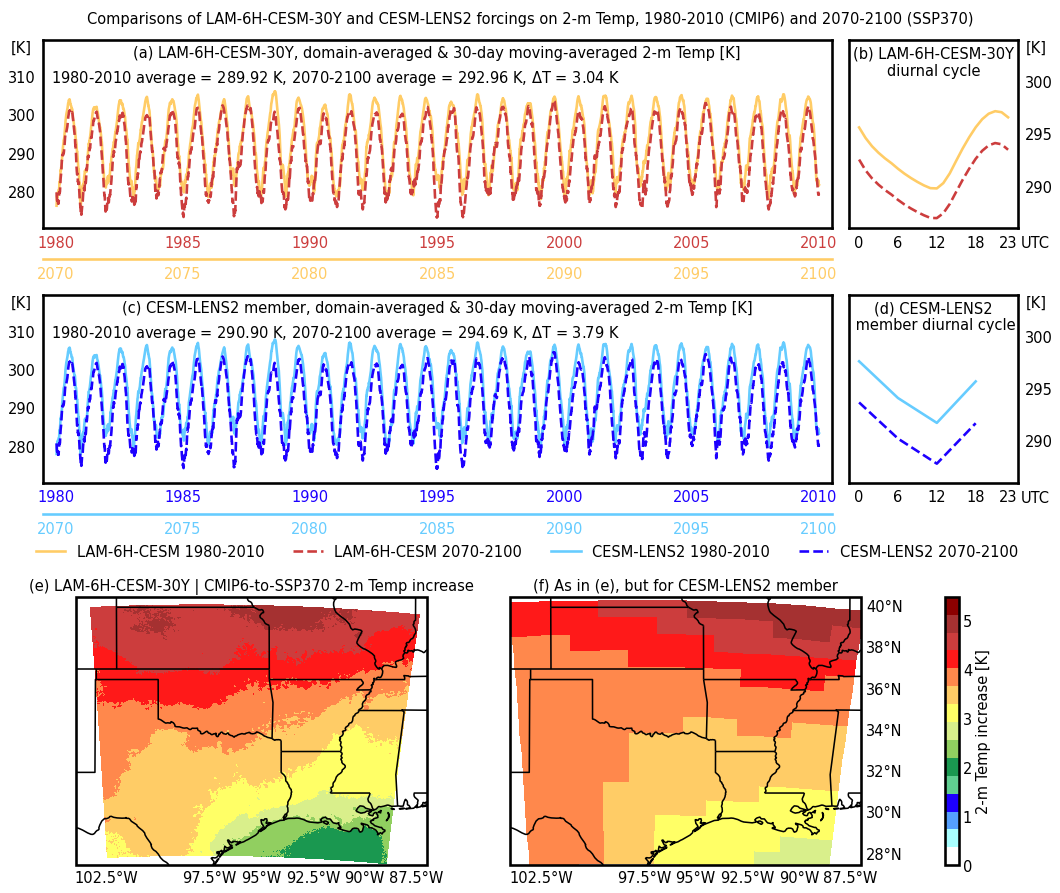

In [21]:
proj_ = ccrs.PlateCarree()
map_extent = [-104, -87, 27.5, 40.5]

fig = plt.figure(figsize=(13, 11), dpi=dpi_)
gs = gridspec.GridSpec(27, 16, height_ratios=[1,]*7+[2.5,]+[1,]*7+[3.25,]+[1,]*11, width_ratios=[1,]*16)

AX_lines = []
AX_lines.append(plt.subplot(gs[0:7, 0:13]))
AX_lines.append(plt.subplot(gs[8:15, 0:13]))

AX_cycle = []
AX_cycle.append(plt.subplot(gs[0:7, 13:16]))
AX_cycle.append(plt.subplot(gs[8:15, 13:16]))

AX_maps = []
AX_maps.append(plt.subplot(gs[17:27, 0:7], projection=proj_))
AX_maps.append(plt.subplot(gs[17:27, 7:14], projection=proj_))

for ax in (AX_lines + AX_cycle):
    ax = gu.ax_decorate_box(ax)

AX_append = []

for ax in AX_lines:
    ax.set_ylim([270.5, 319.5])
    ax.tick_params(labelbottom=True, labelleft=True, labelsize=14)
    ax.set_xticks([1980, 1985, 1990, 1995, 2000, 2005, 2010])

    ax_ = ax.secondary_xaxis('bottom')
    [j.set_linewidth(2.5) for j in ax_.spines.values()]

    ax.set_xlim([1979.5, 2010.5])
    ax.text(-0.04, 1, '[K]', ha='left', va='top', fontsize=14, transform=ax.transAxes)
    
    ax_.spines['bottom'].set_position(('outward', 30))
    ax_.tick_params(bottom=False, labelbottom=True, labelsize=14)
    ax_.set_xticks([1980, 1985, 1990, 1995, 2000, 2005, 2010])
    AX_append.append(ax_)


AX_lines[0].set_xticklabels([1980, 1985, 1990, 1995, 2000, 2005, 2010], color=red)
[j.set_color(orange) for j in AX_append[0].spines.values()]
AX_append[0].set_xticklabels(['2070', '2075', '2080', '2085', '2090', '2095', '2100'], color=orange)

AX_lines[1].set_xticklabels([1980, 1985, 1990, 1995, 2000, 2005, 2010], color=blue)
[j.set_color(cyan) for j in AX_append[1].spines.values()]
AX_append[1].set_xticklabels(['2070', '2075', '2080', '2085', '2090', '2095', '2100'], color=cyan)

for ax in AX_cycle:
    ax.set_xlim([-1.5, 24.5])
    ax.set_ylim([286, 304])
    ax.tick_params(labelbottom=True, labelright=True, labelsize=14)
    ax.set_xticks([0, 6, 12, 18, 23])
    ax.text(1.02, -0.04, 'UTC', ha='left', va='top', fontsize=14, transform=ax.transAxes)
    ax.text(1.05, 1, '[K]', ha='left', va='top', fontsize=14, transform=ax.transAxes)
    
for ax in AX_maps:
    ax.set_extent(map_extent, crs=proj_)
    ax = map_gridline_opt(ax)

for i_ax in [1, 0]:
    ax = AX_maps[i_ax]
    GL = ax.gridlines(
        crs=ccrs.PlateCarree(),
        draw_labels=True,
        x_inline=False, y_inline=False,
        color='none', linewidth=0, zorder=5
    )
    GL.xlabel_style = {'size': 14}
    GL.ylabel_style = {'size': 14}
    GL.top_labels = False
    GL.left_labels = False
    GL.right_labels = (i_ax == 1)

plt.subplots_adjust(0, 0, 1, 1, hspace=0, wspace=0.4)

N_ = 60
AX_lines[0].plot(x_time[N_:], WRF_SSP_ave[N_:], **line_keys['WRF_SSP'])
AX_lines[0].plot(x_time[N_:], WRF_HIST_ave[N_:], **line_keys['WRF_HIST'])
WRF_SSP_mean = WRF_SSP_ave[N_:].mean()
WRF_HIST_mean = WRF_HIST_ave[N_:].mean()
dT_ = WRF_SSP_mean - WRF_HIST_mean
AX_lines[0].text(
    0.01, 0.85, 
    '1980-2010 average = {:.2f} K, 2070-2100 average = {:.2f} K, $\Delta$T = {:.2f} K'.format(
        WRF_HIST_mean, WRF_SSP_mean, dT_), ha='left', va='top', fontsize=14, 
    transform=AX_lines[0].transAxes
)

AX_lines[1].plot(x_time[N_:], LENS_SSP_ave[N_:], **line_keys['LENS_SSP'])
AX_lines[1].plot(x_time[N_:], LENS_HIST_ave[N_:], **line_keys['LENS_HIST'])
LENS_SSP_mean = LENS_SSP_ave[N_:].mean()
LENS_HIST_mean = LENS_HIST_ave[N_:].mean()
dT_ = LENS_SSP_mean - LENS_HIST_mean
AX_lines[1].text(
    0.01, 0.85, 
    '1980-2010 average = {:.2f} K, 2070-2100 average = {:.2f} K, $\Delta$T = {:.2f} K'.format(
        LENS_HIST_mean, LENS_SSP_mean, dT_), ha='left', va='top', fontsize=14, 
    transform=AX_lines[1].transAxes
)


x_hour = np.arange(24)
AX_cycle[0].plot(x_hour, WRF_SSP_cycle[0, :], **line_keys['WRF_SSP'])
AX_cycle[0].plot(x_hour, WRF_HIST_cycle[0, :], **line_keys['WRF_HIST'])

x_6hour = x_hour[[0, 6, 12, 18]]
AX_cycle[1].plot(x_6hour, LENS_SSP_cycle[0, ind_], **line_keys['LENS_SSP'])
AX_cycle[1].plot(x_6hour, LENS_HIST_cycle[0, ind_], **line_keys['LENS_HIST'])


CS = AX_maps[0].pcolormesh(
    lon_WRF, lat_WRF, WRF_dT,
    vmin=LIM_t2[0], vmax=LIM_t2[1], cmap=cmap_t2, transform=ccrs.PlateCarree()
)

AX_maps[1].pcolormesh(
    lon_WRF[skip_CESM_x, skip_CESM_y], 
    lat_WRF[skip_CESM_x, skip_CESM_y], 
    LENS_dT[skip_CESM_x, skip_CESM_y],
    vmin=LIM_t2[0], vmax=LIM_t2[1], cmap=cmap_t2, transform=ccrs.PlateCarree()
)

#
ax_base2 = fig.add_axes([0.925, 0.0, 0.05, 0.3255])#
ax_base2.tick_params(
    axis='both', left=False, top=False, right=False, bottom=False, 
    labelleft=False, labeltop=False, labelright=False, labelbottom=False
)
cax2 = inset_axes(ax_base2, height='100%', width='30%', borderpad=0, loc=2)
CBar2 = plt.colorbar(CS, orientation='vertical', cax=cax2)
CBar2.ax.tick_params(axis='y', labelsize=14, direction='in', length=0)
CBar2.outline.set_linewidth(2.5)
# CBar2.set_ticks(np.arange(280, 300+5, 5))
CBar2.ax.set_ylabel('2-m Temp increase [K]', fontsize=14)


AX_lines[0].set_title('(a) LAM-6H-CESM-30Y, domain-averaged & 30-day moving-averaged 2-m Temp [K]', fontsize=14, y=0.875)
AX_lines[1].set_title('(c) CESM-LENS2 member, domain-averaged & 30-day moving-averaged 2-m Temp [K]', fontsize=14, y=0.875)

AX_cycle[0].set_title('(b) LAM-6H-CESM-30Y\ndiurnal cycle', fontsize=14, y=0.78)
AX_cycle[1].set_title('(d) CESM-LENS2\n member diurnal cycle', fontsize=14, y=0.78)

AX_maps[0].set_title('(e) LAM-6H-CESM-30Y | CMIP6-to-SSP370 2-m Temp increase', fontsize=14)
AX_maps[1].set_title('(f) As in (e), but for CESM-LENS2 member', fontsize=14)


handle_legneds1 = []
handle_legneds1.append(mlines.Line2D([], [], **line_keys['WRF_SSP']))
handle_legneds1.append(mlines.Line2D([], [], **line_keys['WRF_HIST']))
handle_legneds1.append(mlines.Line2D([], [], **line_keys['LENS_SSP']))
handle_legneds1.append(mlines.Line2D([], [], **line_keys['LENS_HIST']))


ax_lg1 = fig.add_axes([-0.006, 0.355, 1.02, 0.05])
LG1 = ax_lg1.legend(
    handle_legneds1, 
    ['LAM-6H-CESM 1980-2010', 'LAM-6H-CESM 2070-2100', 
     'CESM-LENS2 1980-2010', 'CESM-LENS2 2070-2100'], 
    bbox_to_anchor=(1, 1), ncol=4, prop={'size':14}
)

ax_title1 = fig.add_axes([0.0, 1.01, 1.0, 0.03])

ax_title1.text(
    0.5, 0.5, 
    'Comparisons of LAM-6H-CESM-30Y and CESM-LENS2 forcings on 2-m Temp, 1980-2010 (CMIP6) and 2070-2100 (SSP370)', 
    fontsize=14, va='center', ha='center', transform=ax_title1.transAxes
)

ax_title1.set_axis_off()
ax_base2.set_axis_off()
LG1 = gu.lg_box(LG1)
ax_lg1.set_axis_off()